In [1]:
import numpy as np 
import torch 
import torch.nn as nn
from matplotlib import pyplot as plt 

device = 'cuda' if torch.cuda.is_available else 'cpu'
print(f'Device = {device}')

Device = cuda


In [2]:
def delta2(x, y, x0=0.5, y0=0.5):
    """Numerical Dirac delta function at (x0, y0)
    """
    assert x.shape == y.shape
    beta = 0.001
    exp = np.exp((-(x - x0)**2 - (y - y0)**2) / beta)
    return exp / (np.pi * beta**2)

In [3]:
class DNN(nn.Module):
    """Fully connected neural network
    """
    def __init__(self, layer_sizes):
        super(DNN, self).__init__()
        self.layer_sizes = layer_sizes
        self.linears = nn.ModuleList()
        for i in range(1, len(layer_sizes)):
            self.linears.append(nn.Linear(layer_sizes[i-1], layer_sizes[i]))

    def forward(self, x):
        for linear in self.linears[:-1]:
            x = torch.tanh(linear(x))
        x = self.linears[-1](x)
        return x 
    
    def predict(self, X):
        self.eval()
        Y_pred = self.forward(X)
        Y_pred = Y_pred.detach().cpu().numpy()
        return Y_pred

In [4]:
def computer_mse_loss(Y_pred, Y_train):
    assert Y_pred.shape == Y_train.shape
    return torch.mean(torch.square(Y_pred-Y_train))

Iter 0, Loss 2.0130e-01
Iter 100, Loss 2.0002e-01
Iter 200, Loss 2.0002e-01
Iter 300, Loss 2.0002e-01
Iter 400, Loss 2.0002e-01
Iter 500, Loss 2.0002e-01
Iter 600, Loss 2.0002e-01
Iter 700, Loss 2.0002e-01
Iter 800, Loss 2.0002e-01
Iter 900, Loss 2.0002e-01
Iter 1000, Loss 2.0002e-01


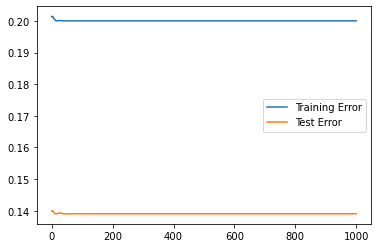

In [32]:
# Training with raw data
num_samples = 10000
X = np.random.rand(num_samples, 2)
Y = delta2(X[:, 0:1], X[:, 1:2])
# Train test split
idx = np.arange(num_samples)
np.random.shuffle(idx)
idx_train = idx[:int(num_samples*0.7)]
idx_test = idx[int(num_samples*0.7):]
X_train = X[idx_train]
Y_train = Y[idx_train]
X_test = X[idx_test]
Y_test = Y[idx_test]
# Model and configurations
layer_sizes = [2] + [128]*5 + [1]
lr = 1
max_niter = 1001
dnn = DNN(layer_sizes)
dnn.to(device)
optimizer = torch.optim.Adam(
    dnn.parameters(),
    lr=lr
)
train_error = []
test_error = []
# Train
for niter in range(max_niter):
    Y_pred = dnn(torch.tensor(X_train, dtype=torch.float32, device=device))
    lt = computer_mse_loss(Y_pred, torch.tensor(Y_train, dtype=torch.float32, device=device)) / 1e9
    train_error.append(lt.item())
    with torch.no_grad():
        Y_pred = dnn(torch.tensor(X_test, dtype=torch.float32, device=device))
        lv = computer_mse_loss(Y_pred, torch.tensor(Y_test, dtype=torch.float32, device=device)) /1e9
        test_error.append(lv.item())
    optimizer.zero_grad()
    lt.backward()
    optimizer.step()

    if niter % 100 == 0 or niter == max_niter - 1:
        print('Iter %d, Loss %.4e' % (niter, lt))
# Plot loss
plt.plot(train_error, label='Training Error')
plt.plot(test_error, label="Test Error")
plt.legend()

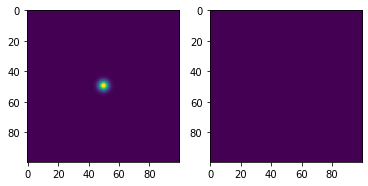

In [31]:
xs = np.linspace(0, 1, 100)
ys = np.linspace(0, 1, 100)
Xs, Ys = np.meshgrid(xs, ys)
X = np.c_[Xs.flatten()[:, np.newaxis], Ys.flatten()[:, np.newaxis]]
Y_label = delta2(X[:, 0], X[:, 1]).reshape(100, 100)
Y_pred = dnn.predict(torch.tensor(X, device=device, dtype=torch.float32))
Y_pred = Y_pred.reshape(100, 100)
plt.subplot(121)
plt.imshow(Y_label)
plt.subplot(122)
plt.imshow(Y_pred)

Iter 0, Loss 1.0000e+00
Iter 100, Loss 9.9947e-01
Iter 200, Loss 9.8095e-01
Iter 300, Loss 5.8814e-01
Iter 400, Loss 3.0650e-02
Iter 500, Loss 8.3834e-03
Iter 600, Loss 2.6960e-03
Iter 700, Loss 1.2853e-03
Iter 800, Loss 1.0799e-03
Iter 900, Loss 1.2135e-02
Iter 1000, Loss 5.6307e-04


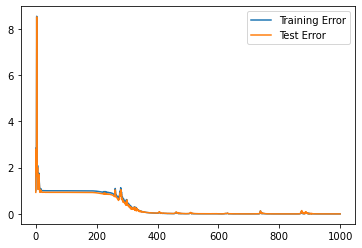

In [16]:
# Training with scaled output
num_samples = 10000
X = np.random.rand(num_samples, 2)
Y = delta2(X[:, 0:1], X[:, 1:2])
# Train test split
idx = np.arange(num_samples)
np.random.shuffle(idx)
idx_train = idx[:int(num_samples*0.7)]
idx_test = idx[int(num_samples*0.7):]
X_train = X[idx_train]
Y_train = Y[idx_train]
X_test = X[idx_test]
Y_test = Y[idx_test]
# Scaled output
sy = Y_train.std()
Y_train = Y_train / sy
# Model and configurations
layer_sizes = [2] + [128]*5 + [1]
lr = 0.01
max_niter = 1001
dnn = DNN(layer_sizes)
dnn.to(device)
optimizer = torch.optim.Adam(
    dnn.parameters(),
    lr=lr
)
train_error = []
test_error = []
# Train
for niter in range(max_niter):
    Y_pred = dnn(torch.tensor(X_train, dtype=torch.float32, device=device))
    lt = computer_mse_loss(Y_pred, torch.tensor(Y_train, dtype=torch.float32, device=device))
    train_error.append(lt.item())
    with torch.no_grad():
        Y_pred = dnn(torch.tensor(X_test, dtype=torch.float32, device=device)) 
        lv = computer_mse_loss(Y_pred, torch.tensor(Y_test, dtype=torch.float32, device=device) / sy)
        test_error.append(lv.item())
    optimizer.zero_grad()
    lt.backward()
    optimizer.step()

    if niter % 100 == 0 or niter == max_niter - 1:
        print('Iter %d, Loss %.4e' % (niter, lt))
# Plot loss
plt.plot(train_error, label='Training Error')
plt.plot(test_error, label="Test Error")
plt.legend()

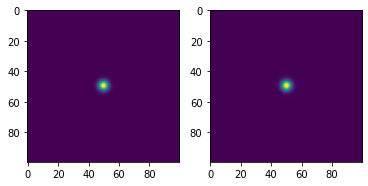

In [17]:
xs = np.linspace(0, 1, 100)
ys = np.linspace(0, 1, 100)
Xs, Ys = np.meshgrid(xs, ys)
X = np.c_[Xs.flatten()[:, np.newaxis], Ys.flatten()[:, np.newaxis]]
Y_label = delta2(X[:, 0], X[:, 1]).reshape(100, 100)
Y_pred = dnn.predict(torch.tensor(X, device=device, dtype=torch.float32))
Y_pred = (Y_pred * sy).reshape(100, 100)
plt.subplot(121)
plt.imshow(Y_label)
plt.subplot(122)
plt.imshow(Y_pred)

Iter 0, Loss 1.7805e+08
Iter 100, Loss 1.7714e+08
Iter 200, Loss 1.7531e+08
Iter 300, Loss 1.7248e+08
Iter 400, Loss 1.6986e+08
Iter 500, Loss 1.6729e+08
Iter 600, Loss 1.6491e+08
Iter 700, Loss 1.6258e+08
Iter 800, Loss 1.6034e+08
Iter 900, Loss 1.6351e+08
Iter 1000, Loss 1.6138e+08


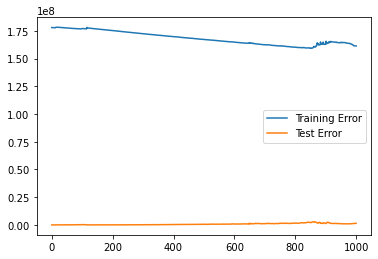

In [32]:
# Training with scaled intput
num_samples = 10000
X = np.random.rand(num_samples, 2)
Y = delta2(X[:, 0:1], X[:, 1:2])
# Train test split
idx = np.arange(num_samples)
np.random.shuffle(idx)
idx_train = idx[:int(num_samples*0.7)]
idx_test = idx[int(num_samples*0.7):]
X_train = X[idx_train]
Y_train = Y[idx_train]
X_test = X[idx_test]
Y_test = Y[idx_test]
# Scaled input
mx = X_train.mean(axis=0, keepdims=True)
sx = X_train.std(axis=0, keepdims=True)
X_train = (X_train -mx) / sx
X_test = (X_test - mx) / sx
# Model and configurations
layer_sizes = [2] + [128]*5 + [1]
lr = 0.
max_niter = 1001
dnn = DNN(layer_sizes)
dnn.to(device)
optimizer = torch.optim.Adam(
    dnn.parameters(),
    lr=lr
)
train_error = []
test_error = []
# Train
for niter in range(max_niter):
    Y_pred = dnn(torch.tensor(X_train, dtype=torch.float32, device=device))
    lt = computer_mse_loss(Y_pred, torch.tensor(Y_train, dtype=torch.float32, device=device))
    train_error.append(lt.item())
    with torch.no_grad():
        Y_pred = dnn(torch.tensor(X_test, dtype=torch.float32, device=device)) 
        lv = computer_mse_loss(Y_pred, torch.tensor(Y_test, dtype=torch.float32, device=device) / sy)
        test_error.append(lv.item())
    optimizer.zero_grad()
    lt.backward()
    optimizer.step()

    if niter % 100 == 0 or niter == max_niter - 1:
        print('Iter %d, Loss %.4e' % (niter, lt))
# Plot loss
plt.plot(train_error, label='Training Error')
plt.plot(test_error, label="Test Error")
plt.legend()

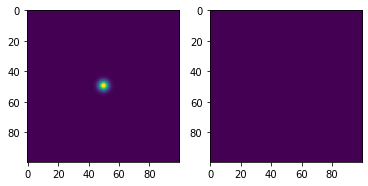

In [31]:
xs = np.linspace(0, 1, 100)
ys = np.linspace(0, 1, 100)
Xs, Ys = np.meshgrid(xs, ys)
X = np.c_[Xs.flatten()[:, np.newaxis], Ys.flatten()[:, np.newaxis]]
Y_label = delta2(X[:, 0], X[:, 1]).reshape(100, 100)
X = (X-mx) / sx
Y_pred = dnn.predict(torch.tensor(X, device=device, dtype=torch.float32))
Y_pred = (Y_pred * sy).reshape(100, 100)
plt.subplot(121)
plt.imshow(Y_label)
plt.subplot(122)
plt.imshow(Y_pred)